In [1]:
import ast
import astunparse
import base64
import itertools
import json
import scipy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from mpl_helper import make_fig, make_fig_array, remove_fig_array_axes
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
# Marker identification funcions
def has_advanced_syntax(qid, code):
    # These questions come with comprehension in the given code
    if qid in ['fixListComprehension', 'modifyConditionalListComprehension', 
               'modifyFindLargestNumberInCSV_C_mod', 'modifyFindLargestNumberInCSV_D_mod', 
               'modifyFindLargestNumberInCSV_P_mod']:
        return False
    for node in ast.walk(ast.parse(code)):
        if type(node) in [ast.ListComp, ast.SetComp, ast.DictComp, ast.GeneratorExp, ast.Lambda]:
            return True
        if type(node) in [ast.Call]:
            if isinstance(node.func, ast.Name):
                if node.func.id in ['map', 'filter']:
                    return True
    return False

def has_extra_comment(qid, code):
    # Some questions' given code has these comments
    builtin_comments = [
        b'# Implement your function here.  Be sure to indent your code block!',
        b'# Your code here',
        b'# a float',
        b'# an integer',
        b'# init implementation',
        b'# print name implementation',
        b'# replace with your return statement',
        b'# write your statement here',
        b'#List comprehensions are cool',
        b'#List comprehensions are cool',
        b'#List comprehensions are cool, this turns all the strings from split into ints'
    ]
    if b"'''" in code or b'"""' in code:
        return True
    if b'#' in code:
        splits = code.split(b'#')
        for split in splits[1:]:
            comment = split.split(b'\n')[0]
            if b'#' + comment not in builtin_comments:
                return True
    return False

def has_extra_print(qid, code):
    # These questions require printing
    if 'Print' in qid or qid in ['fixAreaTrapezoid', 'fixFormatPrecision', 'fixFunctionTypeCasting', 
                                 'fixInputConversion', 'fixVariableDecrement', 'modifyFindIndexInList_C2', 
                                 'modifyFormatPrecision_C', 'modifyGetValueIfKeyExists_D', 
                                 'modifyHandleExtremeCond_D', 'modifyHandleExtreme_D', 'progCreateClass_A', 
                                 'progReadFileLines', 'progReadFileLines_C', 'progReadFileLines_ODC', 
                                 'progReadFileLines_RF']:
        return False
    for node in ast.walk(ast.parse(code)):
        if type(node) in [ast.Call]:
            if isinstance(node.func, ast.Name):
                if node.func.id in ['print']:
                    return True
    return False

def has_extra_code(qid, code):
    # These questions are early in the semester questions before the introduction of functions
    if qid in ['fixAreaTrapezoid', 'fixInputConversion', 'fixPrintStatement2', 'fixVariableDecrement']:
        return False
    p = ast.parse(code)
    num_components = 0
    for node in p.body:
        if not isinstance(node, ast.Import) and not isinstance(node, ast.ImportFrom):
            num_components += 1
    return num_components > 1

# Loading Actual Exam/Quiz Score Data

In [3]:
instance_question_actual_df = pd.read_csv('instance_questions_cs105.zip', compression='zip')

In [4]:
instance_question_actual_df['unique_id'] = (instance_question_actual_df['semester']
                                            + '_' + instance_question_actual_df['user_id'].astype(str))
instance_question_actual_df = instance_question_actual_df[instance_question_actual_df.semester.isin(['fa22', 'sp23'])]
exam1_unique_ids = instance_question_actual_df[(instance_question_actual_df.assessment_set_name == 'Exam')
                                               & (instance_question_actual_df.assessment_number == 1)].unique_id
exam4_unique_ids = instance_question_actual_df[(instance_question_actual_df.assessment_set_name == 'Exam')
                                               & (instance_question_actual_df.assessment_number == 4)].unique_id

In [5]:
# Find semester user_id combos that have done both exam1 and exam4
unique_ids = set(exam1_unique_ids).intersection(exam4_unique_ids)

In [6]:
# Filter by unique_ids, which is the semester user_id combos that have done both exam1 and exam4
score_actual_df = instance_question_actual_df[instance_question_actual_df.unique_id.isin(unique_ids)].copy()

In [7]:
score_actual_df = (score_actual_df
                   .groupby(['semester', 'user_id', 'assessment_set_name', 'assessment_number'])
                   .agg('sum')
                   .reset_index())
score_actual_df['score_perc'] = score_actual_df.apply(lambda row : (100 
                                                                    * row['instance_question_points'] 
                                                                    / row['assessment_question_max_points']), 
                                                      axis=1)
score_actual_df = score_actual_df[['semester', 'user_id', 
                                   'assessment_set_name', 'assessment_number', 
                                   'score_perc']].copy()

In [8]:
# objects are strings
score_actual_df.dtypes

semester                object
user_id                  int64
assessment_set_name     object
assessment_number        int64
score_perc             float64
dtype: object

In [9]:
score_actual_df.describe()

,user_id,assessment_number,score_perc
count,8.716000e+03,8716.000000,8716.000000
mean,4.186264e+06,2.218334,82.935399
std,6.685133e+05,1.315494,15.350376
min,1.299640e+05,0.000000,0.000000
25%,4.316445e+06,1.000000,77.106984
50%,4.319873e+06,2.000000,87.680097
75%,4.369417e+06,3.000000,93.819257
max,4.422763e+06,4.000000,100.000000


In [10]:
score_actual_pivot_df = (score_actual_df
                         .pivot(index=['semester', 'user_id'], 
                                columns=['assessment_set_name', 'assessment_number'], 
                                values='score_perc')
                         .reset_index())
score_actual_pivot_df.columns = ['semester', 'user_id', 
                                 'exam0', 'exam1', 'exam2', 'exam3', 'exam4', 
                                 'quiz1', 'quiz2', 'quiz3', 'quiz4']

In [11]:
# Number of students in each semester
print(len(score_actual_df[score_actual_df.semester == 'fa22'].user_id.unique()))
print(len(score_actual_df[score_actual_df.semester == 'sp23'].user_id.unique()))

550
433


In [12]:
# objects are strings
score_actual_pivot_df.dtypes

semester     object
user_id       int64
exam0       float64
exam1       float64
exam2       float64
exam3       float64
exam4       float64
quiz1       float64
quiz2       float64
quiz3       float64
quiz4       float64
dtype: object

In [13]:
score_actual_pivot_df.describe()

,user_id,exam0,exam1,exam2,exam3,exam4,quiz1,quiz2,quiz3,quiz4
count,9.830000e+02,972.000000,983.000000,976.000000,975.000000,983.000000,964.000000,961.000000,951.000000,951.000000
mean,4.184074e+06,87.394239,83.370227,78.879903,69.809910,75.857219,90.237628,87.972522,83.385594,89.921498
std,6.746661e+05,9.521232,12.305887,16.265694,20.491058,18.017582,9.481180,10.733512,12.673404,10.571796
min,1.299640e+05,32.000000,23.733333,18.918919,7.432432,0.000000,30.220000,0.000000,13.513514,20.666667
25%,4.316443e+06,83.000000,78.000000,70.386507,56.787162,65.380807,87.333333,84.086667,78.219595,87.356667
50%,4.319853e+06,90.000000,86.133333,82.557047,73.054054,80.286885,93.330000,90.933333,86.054054,93.166667
75%,4.369414e+06,93.000000,92.366667,91.489933,86.506757,90.022516,96.000000,95.333333,92.483108,96.666667
max,4.422763e+06,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


# Loading Predicted Exam/Quiz Score Data

In [14]:
instance_question_predicted_df = pd.read_csv('irt_prediction_l@s_max_a_2.zip', compression='zip')

In [15]:
# Filter by unique_ids, which is the semester user_id combos that have done both exam1 and exam4
instance_question_predicted_df['unique_id'] = instance_question_predicted_df['semester'] + '_' + instance_question_predicted_df['user_id'].astype(str)
instance_question_predicted_df = instance_question_predicted_df[instance_question_predicted_df.unique_id.isin(unique_ids)].copy()

In [16]:
assessment_prediction_dfs = []
for semester in ['fa22', 'sp23']:
    for assessment_set_name in ['Exam', 'Quiz']:
        for assessment_number in [1, 2, 3, 4]:
            info_assessment = json.load(open(f'pl_assessment_info/{semester}/{assessment_set_name.lower()}{assessment_number}/infoAssessment.json'))
            
            assessment_df = instance_question_predicted_df[(instance_question_predicted_df.assessment_set_name == assessment_set_name)
                                                           & (instance_question_predicted_df.assessment_number == assessment_number)]
            
            question_slot_dfs = []
            for zone in info_assessment['zones']:
                for question_slot in zone['questions']:
                    
                    # figure out number of questions to be chosen for the slot
                    # and all questions in the slot
                    
                    # if 'id' is in the dictionary, it is a single question, otherwise a question pool
                    if 'id' in question_slot: 
                        num_choose = 1
                        questions = [question_slot['id']]
                    else:
                        if len(question_slot['alternatives']) > 1:
                            num_choose = question_slot['numberChoose']
                        else:
                            num_choose = 1

                        questions = []
                        for question in question_slot['alternatives']:
                            questions.append(question['id'])
                            
                    # number of points the question slot offers
                    if isinstance(question_slot['points'], int):
                        num_points = question_slot['points']
                    else:
                        num_points = question_slot['points'][0]
            
                    question_slot_df = assessment_df[assessment_df.question_name.isin(questions)].groupby('unique_id').agg({'prediction' : 'mean'}).reset_index()
                    question_slot_df['points'] = num_points * num_choose * question_slot_df['prediction']
                    question_slot_df['max_points'] = num_points * num_choose

                    question_slot_dfs.append(question_slot_df)
            
            assessment_prediction_df = pd.concat(question_slot_dfs).groupby('unique_id').agg('sum').reset_index()
            assessment_prediction_df['semester'] = assessment_prediction_df['unique_id'].apply(lambda s : s.split('_')[0])
            assessment_prediction_df['user_id'] = assessment_prediction_df['unique_id'].apply(lambda s : int(s.split('_')[1]))
            assessment_prediction_df['assessment_set_name'] = assessment_set_name
            assessment_prediction_df['assessment_number'] = assessment_number
            assessment_prediction_df['score_perc'] = 100 * assessment_prediction_df['points'] / assessment_prediction_df['max_points']
            assessment_prediction_df['version'] = semester
            
            assessment_prediction_dfs.append(assessment_prediction_df)

In [17]:
score_predicted_df = pd.concat(assessment_prediction_dfs)
score_predicted_df = score_predicted_df.groupby(['semester', 'user_id', 'assessment_set_name', 'assessment_number']).agg({'score_perc' : 'mean'}).reset_index()

In [18]:
# objects are strings
score_predicted_df.dtypes

semester                object
user_id                  int64
assessment_set_name     object
assessment_number        int64
score_perc             float64
dtype: object

In [19]:
score_predicted_df.describe()

,user_id,assessment_number,score_perc
count,7.744000e+03,7744.000000,7744.000000
mean,4.186536e+06,2.496772,82.418204
std,6.674947e+05,1.119141,15.335756
min,1.299640e+05,1.000000,25.558407
25%,4.316445e+06,1.000000,75.988475
50%,4.319853e+06,2.000000,87.225609
75%,4.369417e+06,3.000000,93.697886
max,4.422763e+06,4.000000,98.527152


In [20]:
score_predicted_pivot_df = (score_predicted_df
                            .pivot(index=['semester', 'user_id'], 
                                   columns=['assessment_set_name', 'assessment_number'], 
                                   values='score_perc')
                            .reset_index())
score_predicted_pivot_df.columns = ['semester', 'user_id', 
                                    'exam1', 'exam2', 'exam3', 'exam4', 
                                    'quiz1', 'quiz2', 'quiz3', 'quiz4']

In [21]:
# objects are strings
score_predicted_pivot_df.dtypes

semester     object
user_id       int64
exam1       float64
exam2       float64
exam3       float64
exam4       float64
quiz1       float64
quiz2       float64
quiz3       float64
quiz4       float64
dtype: object

In [22]:
score_predicted_pivot_df.describe()

,user_id,exam1,exam2,exam3,exam4,quiz1,quiz2,quiz3,quiz4
count,9.830000e+02,983.000000,976.000000,975.000000,983.000000,964.000000,961.000000,951.000000,951.000000
mean,4.184074e+06,83.493131,78.908352,70.057242,75.971229,90.128763,88.010347,83.462328,89.735017
std,6.746661e+05,11.519918,15.617045,19.911867,17.397210,8.969639,10.435443,12.017798,10.662634
min,1.299640e+05,51.181452,35.498990,25.558407,27.385757,50.126973,42.262070,33.060755,28.033763
25%,4.316443e+06,77.228577,70.354466,56.922017,65.668749,87.131034,84.570551,77.888518,87.424397
50%,4.319853e+06,85.748970,82.039102,72.566172,80.591028,92.800505,91.053012,86.234246,92.786058
75%,4.369414e+06,92.344631,91.604363,86.686180,89.833027,95.944161,95.234949,92.494498,96.599815
max,4.422763e+06,98.527152,98.248458,98.107347,98.025567,98.376359,98.254889,97.494573,98.204842


# Loading Homework/Exam/Quiz Programming Question Submission Data

In [23]:
question_type_df = pd.read_csv('question_types.csv')

submission_dfs = []
for semester in ['fa22', 'sp23']:
    submission_df = pd.read_csv(f'log_cs105{semester}_with_submitted_answer.zip', compression='zip')
    submission_df['semester'] = semester
    submission_df['timedelta_second'] = (pd
                                         .to_timedelta(submission_df['timedelta'])
                                         .apply(lambda timedelta : timedelta.total_seconds()))
    
    submission_df = submission_df.merge(question_type_df, 
                                        left_on='qid', 
                                        right_on='question_name').drop('qid', axis=1)
    submission_df = submission_df[submission_df.question_type == 'programming']
    submission_dfs.append(submission_df)
submission_df = (pd
                 .concat(submission_dfs)
                 .dropna(subset=['submitted_answer'])) # need to accumulate timedelta if ever want to analyze time
                                                       # dropped save only submissions since not analyzing time

# Filter by unique_ids
submission_df['unique_id'] = submission_df['semester'] + '_' + submission_df['user_id'].astype(str)
submission_df = submission_df[submission_df.unique_id.isin(unique_ids)].copy()

submission_df['submitted_code'] = (submission_df
                                   .submitted_answer
                                   .apply(lambda s : (base64
                                                      .b64decode(eval(s)['_files'][0]['contents'])
                                                      .strip())))
# Have to do this because some code has strange ending sequence that ast.parse complains about
submission_df['submitted_code'] = (submission_df
                                   .submitted_code
                                   .apply(lambda s : s[0:-1] if s.endswith(b'\\') else s[0:]))

submission_df = submission_df[['semester', 'user_id', 
                               'assessment_set_name', 'assessment_number', 
                               'question_name', 'correct', 'timedelta_second', 
                               'submitted_code']].copy()

# Apply marker detections
for col_name, func_name in [('syntax', has_advanced_syntax), 
                            ('comment', has_extra_comment), 
                            ('print', has_extra_print), 
                            ('code', has_extra_code)]:
    submission_df[col_name] = submission_df.apply(lambda row : func_name(row['question_name'], 
                                                                         row['submitted_code']), 
                                                  axis=1)

# The any marker
submission_df['any'] = submission_df.apply(lambda row : True if row['syntax'] 
                                           or row['comment'] 
                                           or row['print'] 
                                           or row['code'] else False, axis=1)

In [24]:
# objects are strings
submission_df.dtypes

semester                object
user_id                  int64
assessment_set_name     object
assessment_number        int64
question_name           object
correct                   bool
timedelta_second       float64
submitted_code          object
syntax                    bool
comment                   bool
print                     bool
code                      bool
any                       bool
dtype: object

In [25]:
submission_df.describe()

,user_id,assessment_number,timedelta_second
count,2.945250e+05,294525.000000,294525.000000
mean,4.218140e+06,6.495625,192.824036
std,5.866759e+05,3.313608,354.384517
min,1.299640e+05,1.000000,0.581000
25%,4.316447e+06,4.000000,48.953000
50%,4.319843e+06,6.000000,97.266000
75%,4.369418e+06,9.000000,198.498000
max,4.422763e+06,100.000000,12962.089000


# Loading Chegg Chatgpt Data and Compute Marker Ratios

In [26]:
# Top 5 in each marker, there are overlaps
base_qids = ['fixBankAccountClass', 'fixRemovalFromList', 'progAppendRangeToList', 'progExtractHtmlTitle',
             'progExtractListFromHtml', 'progMaxFromCSV', 'progMaxFromCSV_R', 'progMaxFromCSV_V', 
             'progMiddleTenChars_PF', 'progNestedDictEmployee', 'progReturnCSVfromList', 'progReturnRandomNumber',
             'progReturnSecondWordHard', 'progSubstitutionCipher', 'progSumColumns']
# Radom from the rest
extra_qids = ['progAverageNumbersFromFile_AF', 'progFindLargestInteger', 'progFindShortestStringWithChar_C',
              'progIncreaseTermsByX_P', 'progLargestNumValueInDict_D', 'progThreeLargestNumbersHard',
              'progThreeLargestNumbers_V', 'progWhichVowelsInSentence_P']

In [27]:
chegg_df = pd.read_csv('chegg.csv')
chatgpt_df = pd.read_csv('chatGPT.csv')
cheat_df = pd.concat([chegg_df, chatgpt_df.drop(columns=['qid'])], axis=1)

chegg_cols = ['chegg', 'chegg 2', 'chegg 3', 'chegg 4', 'coursehero', 'coursehero 2', 'brainly', 
              'numerade', 'numerade 2', 'quizlet', 'quizlet 2']
chatgpt_cols = [str(i) for i in range(10)]

In [28]:
# We weigh on each question, rather than each chegg solution found
question_names = []
markers = []
sources = []
marker_ratios = []

for _, row in cheat_df.iterrows():
    for marker, func in zip(['syntax', 'comment', 'print', 'code'], 
                            [has_advanced_syntax, has_extra_comment, has_extra_print, has_extra_code]):
        chegg_count = 0
        chegg_total = 0
        for col in chegg_cols:
            if type(row[col]) is str:
                chegg_count += (func(row['qid'], row[col].encode()) > 0)
                chegg_total += 1
        chatgpt_count = 0
        chatgpt_total = 0
        for col in chatgpt_cols:
            if type(row[col]) is str:
                chatgpt_count += (func(row['qid'], row[col].encode()) > 0)
                chatgpt_total += 1
        
        question_names.append(row['qid'])
        markers.append(marker)
        sources.append('Chegg etc.')
        marker_ratios.append(chegg_count/chegg_total)
        
        question_names.append(row['qid'])
        markers.append(marker)
        sources.append('ChatGPT')
        marker_ratios.append(chatgpt_count/chatgpt_total)

for _, row in cheat_df.iterrows():
    chegg_count = 0
    chegg_total = 0
    for col in chegg_cols:
        if type(row[col]) is str:
            any_marker = False
            for func in [has_advanced_syntax, has_extra_comment, has_extra_print, has_extra_code]:
                if func(row['qid'], row[col].encode()) > 0:
                    any_marker = True
                    break
            chegg_count += any_marker
            chegg_total += 1
    chatgpt_count = 0
    chatgpt_total = 0
    for col in chatgpt_cols:
        if type(row[col]) is str:
            any_marker = False
            for func in [has_advanced_syntax, has_extra_comment, has_extra_print, has_extra_code]:
                if func(row['qid'], row[col].encode()) > 0:
                    any_marker = True
                    break
            chatgpt_count += any_marker
            chatgpt_total += 1

    question_names.append(row['qid'])
    markers.append('any')
    sources.append('Chegg etc.')
    marker_ratios.append(chegg_count/chegg_total)

    question_names.append(row['qid'])
    markers.append('any')
    sources.append('ChatGPT')
    marker_ratios.append(chatgpt_count/chatgpt_total)

plagirism_df = pd.DataFrame.from_records({
    'question_name' : question_names,
    'marker' : markers,
    'source' : sources,
    'marker_ratio' : np.array(marker_ratios)
})

plagirism_df['marker_ratio'] = 100 * plagirism_df['marker_ratio']

# Applying Markers to Each Assessment Type

In [29]:
# Only taking first corret submission for analysis
marker_df = (submission_df[((submission_df.assessment_set_name.isin(['Exam', 'Quiz']) 
                             & submission_df.assessment_number.isin([1, 2, 3, 4])))
                           | (submission_df.assessment_set_name == 'Homework')]
             .drop_duplicates(subset=['semester', 'user_id', 
                                      'assessment_set_name', 'assessment_number', 
                                      'question_name'])
             .copy())
marker_df['count'] = 1
marker_df = (marker_df
             .groupby(['semester', 'user_id', 'assessment_set_name', 'assessment_number']).agg('sum')
             .reset_index())

marker_df = marker_df[['semester', 'user_id', 
                       'assessment_set_name', 'assessment_number', 
                       'syntax', 'comment', 'print', 'code', 'any', 'count']].copy()

# Compute maximum number of programming questions in each assessment, assuming some student solved all of them
# After manual verification this assumption is actually True, including exams
for (semester, assessment_set_name, assessment_number), sub_df in marker_df.groupby(['semester', 
                                                                                     'assessment_set_name', 
                                                                                     'assessment_number']):
    marker_df.loc[(marker_df.semester == semester)
                  & (marker_df.assessment_set_name == assessment_set_name) 
                  & (marker_df.assessment_number == assessment_number), 'total'] = sub_df['count'].max()

In [30]:
# objects are strings
marker_df.dtypes

semester                object
user_id                  int64
assessment_set_name     object
assessment_number        int64
syntax                   int64
comment                  int64
print                    int64
code                     int64
any                      int64
count                    int64
total                  float64
dtype: object

In [31]:
marker_df.describe()

,user_id,assessment_number,syntax,comment,print,code,any,count,total
count,1.886800e+04,18868.000000,18868.000000,18868.000000,18868.000000,18868.000000,18868.000000,18868.000000,18868.000000
mean,4.185702e+06,5.509964,0.153805,0.268391,0.173044,0.162444,0.543725,6.768338,9.040545
std,6.691445e+05,3.762896,0.471460,0.979703,0.593869,0.598186,1.255104,3.972626,5.164942
min,1.299640e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
25%,4.316441e+06,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,6.000000
50%,4.319847e+06,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000
75%,4.369417e+06,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,12.000000
max,4.422763e+06,13.000000,4.000000,13.000000,8.000000,8.000000,13.000000,22.000000,22.000000


# Computing Marker Ratios (Plagiarism Ratios) for Each Assessment Type

In [32]:
marker_ratio_df = (marker_df
                   .groupby(['semester', 'user_id', 'assessment_set_name'])
                   .agg('sum')
                   .reset_index())

for marker in ['syntax', 'comment', 'print', 'code', 'any', 'total']:
    marker_ratio_df[marker] = marker_ratio_df[marker].astype(float)

for semester in ['fa22', 'sp23']:
    for assessment in ['Homework', 'Quiz', 'Exam']:
        for marker in ['syntax', 'comment', 'print', 'code', 'any']:
            marker_ratio_df.loc[(marker_ratio_df.semester == semester)
                                & (marker_ratio_df.assessment_set_name == assessment), marker] = (
                100 * marker_ratio_df.loc[(marker_ratio_df.semester == semester)
                                          & (marker_ratio_df.assessment_set_name == assessment), f'{marker}'] 
                / marker_ratio_df.loc[(marker_ratio_df.semester == semester)
                                      & (marker_ratio_df.assessment_set_name == assessment), 'total'].max()
            )

marker_ratio_df = (marker_ratio_df[['semester', 'user_id', 'assessment_set_name', 
                                    'syntax', 'comment', 'print', 'code', 'any']])

marker_ratio_df = marker_ratio_df.melt(id_vars=['semester', 'user_id', 'assessment_set_name'], 
                                       value_vars=['syntax', 'comment', 'print', 'code', 'any'], 
                                       var_name='marker', 
                                       value_name='ratio')

In [33]:
# objects are strings
marker_ratio_df.dtypes

semester                object
user_id                  int64
assessment_set_name     object
marker                  object
ratio                  float64
dtype: object

In [34]:
marker_ratio_df.describe()

,user_id,ratio
count,1.461000e+04,14610.000000
mean,4.183988e+06,1.917108
std,6.738153e+05,4.109578
min,1.299640e+05,0.000000
25%,4.316442e+06,0.000000
50%,4.319850e+06,0.000000
75%,4.369417e+06,1.526718
max,4.422763e+06,42.857143


In [35]:
marker_ratio_pivot_df = (marker_ratio_df
                         .pivot(index=['semester', 'user_id'], 
                                columns=['marker', 'assessment_set_name'], 
                                values='ratio')
                         .reset_index())
marker_ratio_pivot_df.columns = ['semester', 'user_id', 
                                 'syntax_exam', 'syntax_homework', 'syntax_quiz', 
                                 'comment_exam', 'comment_homework', 'comment_quiz', 
                                 'print_exam', 'print_homework', 'print_quiz', 
                                 'code_exam', 'code_homework', 'code_quiz', 
                                 'any_exam', 'any_homework', 'any_quiz']

In [36]:
# objects are strings
marker_ratio_pivot_df.dtypes

semester             object
user_id               int64
syntax_exam         float64
syntax_homework     float64
syntax_quiz         float64
comment_exam        float64
comment_homework    float64
comment_quiz        float64
print_exam          float64
print_homework      float64
print_quiz          float64
code_exam           float64
code_homework       float64
code_quiz           float64
any_exam            float64
any_homework        float64
any_quiz            float64
dtype: object

In [37]:
marker_ratio_pivot_df.describe()

,user_id,syntax_exam,syntax_homework,syntax_quiz,comment_exam,comment_homework,comment_quiz,print_exam,print_homework,print_quiz,code_exam,code_homework,code_quiz,any_exam,any_homework,any_quiz
count,9.830000e+02,965.000000,982.000000,975.000000,965.000000,982.000000,975.000000,965.000000,982.000000,975.000000,965.000000,982.000000,975.000000,965.000000,982.000000,975.000000
mean,4.184074e+06,0.244010,1.885253,2.002442,0.340699,3.631425,1.406593,0.101265,2.325134,1.133089,0.105251,2.160535,1.186813,0.712694,7.130377,4.253968
std,6.746661e+05,1.012106,2.284852,3.723701,1.265126,5.235353,4.102505,0.908963,3.252924,3.232404,1.005729,3.410058,3.365228,1.987424,6.702443,6.431815
min,1.299640e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.316443e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.526718,0.000000
50%,4.319853e+06,0.000000,0.763359,0.000000,0.000000,1.515152,0.000000,0.000000,0.763359,0.000000,0.000000,0.763359,0.000000,0.000000,5.303030,0.000000
75%,4.369414e+06,0.000000,2.290076,4.761905,0.000000,5.303030,0.000000,0.000000,3.030303,0.000000,0.000000,2.290076,0.000000,0.000000,10.606061,4.761905
max,4.422763e+06,11.111111,9.923664,19.047619,11.538462,35.114504,33.333333,22.222222,21.969697,33.333333,25.925926,22.727273,33.333333,29.629630,41.221374,42.857143


# Mean Quiz (Unproctored) Advantage

In [38]:
quiz_advantage_df = score_actual_pivot_df.copy()
for i in range(1, 5):
    quiz_advantage_df[f'{i}'] = quiz_advantage_df[f'quiz{i}'] - quiz_advantage_df[f'exam{i}']

quiz_advantage_df = quiz_advantage_df.melt(id_vars=['semester', 'user_id'], 
                                           value_vars=['1', '2', '3', '4'], 
                                           var_name='quiz', 
                                           value_name='advantage')

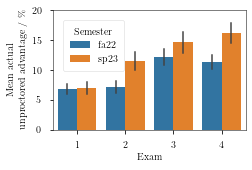

In [39]:
fig, axes = make_fig(figure_width=3.3367, 
                     axis_ratio=(1 + np.sqrt(5)) / 2, 
                     top_margin=0.05, 
                     bottom_margin=0.45, 
                     left_margin=0.65, 
                     right_margin=0.01)

sns.barplot(data=quiz_advantage_df, x='quiz', y='advantage', hue='semester')

plt.legend(title='Semester')

plt.ylim(0, 20)

plt.xlabel('Exam')
plt.ylabel('Mean actual\nunproctored advantage / \%')

plt.savefig('mean_quiz_advantage.pdf')

In [40]:
# t-test for whether there is significant difference in advantage
for i in range(1, 5):
    print(ttest_ind(quiz_advantage_df[(quiz_advantage_df.semester == 'fa22') 
                                      & (quiz_advantage_df.quiz == str(i))].dropna()['advantage'],
                    quiz_advantage_df[(quiz_advantage_df.semester == 'sp23') 
                                      & (quiz_advantage_df.quiz == str(i))].dropna()['advantage'], equal_var=False))

TtestResult(statistic=-0.1419227982193663, pvalue=0.8871741492634381, df=861.9870224576161)
TtestResult(statistic=-4.650096314448957, pvalue=3.912456509282758e-06, df=759.4125077913515)
TtestResult(statistic=-2.195104621969805, pvalue=0.028430621858923293, df=835.178470526779)
TtestResult(statistic=-4.951525420787793, pvalue=9.052822138009404e-07, df=769.9762950425367)


# eCDF of Marker Ratios vs Percentage Students

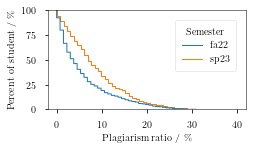

In [41]:
fig, axes = make_fig(figure_width=3.3367, 
                     axis_ratio=2, 
                     top_margin=0.05, 
                     bottom_margin=0.48, 
                     left_margin=0.57, 
                     right_margin=0.01)

ecdf_df = marker_ratio_pivot_df.copy()
ecdf_df['Semester'] = ecdf_df['semester']

sns.ecdfplot(data=ecdf_df, x='any_homework', hue='Semester', stat='percent', complementary=True)

plt.xlim(-2, 42)
plt.ylim(0, 100)

plt.xlabel(r'Plagiarism ratio / \%')
plt.ylabel(r'Percent of student / \%')

plt.savefig('perc_student_vs_marker_ratio_ecdf.pdf')

# Mean Homework Marker Ratio

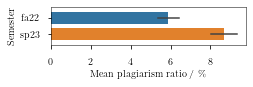

In [42]:
fig, axes = make_fig(figure_width=3.3367, 
                     axis_ratio=5, 
                     top_margin=0.01, 
                     bottom_margin=0.48, 
                     left_margin=0.62, 
                     right_margin=0.01)

sns.barplot(data=marker_ratio_df[(marker_ratio_df.assessment_set_name == 'Homework')
                                 & (marker_ratio_df.marker == 'any')], 
            y='semester', x='ratio', hue='semester', orient='h', order=['sp23', 'fa22'])

plt.ylim(-0.75, 1.75)

plt.xlabel(r'Mean plagiarism ratio / \%')
plt.ylabel(r'Semester')

# It is not a boxplot, was originally a boxplot, too lazy to change latex figure refs
plt.savefig('homework_plagiarism_ratio_boxplot.pdf')

# Evidence for Plagiarism Source Change

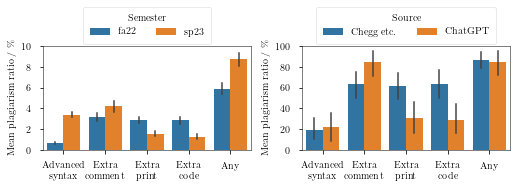

In [43]:
fig, axes = make_fig_array(n_vert=1, 
                           n_horiz=2, 
                           figure_width=7.0056, 
                           axis_ratio=2, 
                           top_margin=0.55, 
                           bottom_margin=0.43, 
                           left_margin=0.50, 
                           right_margin=0.01, 
                           horiz_sep=0.70, 
                           vert_sep=0.00, 
                           share_x_axes=True, 
                           share_y_axes=False)


sns.barplot(data=marker_ratio_df[marker_ratio_df.assessment_set_name == 'Homework'], 
            x='marker', y='ratio', hue='semester', ax=axes[0][0])
axes[0][0].set_ylim(0, 10)
axes[0][0].legend(title='Semester', loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.47))
axes[0][0].set_xticks(axes[0][0].get_xticks())
axes[0][0].set_xticklabels(['Advanced\nsyntax', 'Extra\ncomment', 'Extra\nprint', 'Extra\ncode', 'Any'], 
                           ha='center')
axes[0][0].set_xlabel('')
axes[0][0].set_ylabel('Mean plagiarism ratio / \%')

sns.barplot(data=plagirism_df, x='marker', y='marker_ratio', hue='source', ax=axes[0][1])
axes[0][1].set_ylim(0, 100)
axes[0][1].legend(title='Source', loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.47))
axes[0][1].set_xticks(axes[0][1].get_xticks())
axes[0][1].set_xticklabels(['Advanced\nsyntax', 'Extra\ncomment', 'Extra\nprint', 'Extra\ncode', 'Any'], 
                           ha='center', va='top')
axes[0][1].set_xlabel('')
axes[0][1].set_ylabel('Mean plagiarism ratio / \%')

plt.savefig('plagiarism_source_change_evidence.pdf')

In [44]:
# Upperbound on 1 - false negative rate (sensitivity)
plagirism_df[(plagirism_df.source=='Chegg etc.')
             & (plagirism_df.marker=='any')].marker_ratio.mean()

86.81159420289855

In [45]:
plagirism_df[(plagirism_df.source=='ChatGPT')
             & (plagirism_df.marker=='any')].marker_ratio.mean()

84.78260869565217

In [46]:
# t-test for whether there is significant difference in marker ratios, left plot
for marker in ['syntax', 'comment', 'print', 'code', 'any']:
    print(ttest_ind(marker_ratio_df[(marker_ratio_df.semester == 'fa22')
                                    & (marker_ratio_df.assessment_set_name == 'Homework')
                                    & (marker_ratio_df.marker == marker)]['ratio'],
                    marker_ratio_df[(marker_ratio_df.semester == 'sp23')
                                    & (marker_ratio_df.assessment_set_name == 'Homework')
                                    & (marker_ratio_df.marker == marker)]['ratio'], equal_var=False))

TtestResult(statistic=-20.706082311790045, pvalue=1.0137169268713605e-68, df=485.2485103652275)
TtestResult(statistic=-2.9889513112719284, pvalue=0.002880824123235819, df=841.2720583812641)
TtestResult(statistic=6.606897770779424, pvalue=6.502403811945522e-11, df=957.560278189469)
TtestResult(statistic=7.746248869297733, pvalue=2.508899522034134e-14, df=914.4207802124046)
TtestResult(statistic=-6.587563779712377, pvalue=7.692398489428107e-11, df=878.749481780906)


In [47]:
# t-test for whether there is significant difference in marker ratios, right plot
for marker in ['syntax', 'comment', 'print', 'code', 'any']:
    print(ttest_ind(plagirism_df[(plagirism_df.source == 'Chegg etc.') 
                                 & (plagirism_df.marker == marker)]['marker_ratio'],
                    plagirism_df[(plagirism_df.source == 'ChatGPT')
                                 & (plagirism_df.marker == marker)]['marker_ratio'], equal_var=False))

TtestResult(statistic=-0.2668321649376484, pvalue=0.7909483839270306, df=40.62041448623916)
TtestResult(statistic=-2.4100127117127377, pvalue=0.02020184930251188, df=43.98151511590625)
TtestResult(statistic=3.0023032599096773, pvalue=0.004463057975502909, df=42.73143280680569)
TtestResult(statistic=3.3766283611544496, pvalue=0.0015546265857152573, df=43.50611290846094)
TtestResult(statistic=0.27661949380022893, pvalue=0.7836151808666902, df=36.917051101513046)


In [48]:
# Effect size of the difference on any marker, left plot
from statistics import mean, stdev
from math import sqrt

c0 = marker_ratio_df[(marker_ratio_df.semester == 'fa22')
                     & (marker_ratio_df.assessment_set_name == 'Homework')
                     & (marker_ratio_df.marker == 'any')]['ratio']
c1 = marker_ratio_df[(marker_ratio_df.semester == 'sp23')
                     & (marker_ratio_df.assessment_set_name == 'Homework')
                     & (marker_ratio_df.marker == 'any')]['ratio']

cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))

print(cohens_d)

-0.4259732742625693


# Distribution of Marker Ratios along Time

In [49]:
homework_marker_ratio_df = marker_df[marker_df.assessment_set_name == 'Homework'].copy()

for marker in ['syntax', 'comment', 'print', 'code', 'any']:
    homework_marker_ratio_df[f'{marker}'] = (homework_marker_ratio_df[f'{marker}'] 
                                             / homework_marker_ratio_df['total'])

homework_marker_ratio_df = (homework_marker_ratio_df[['semester', 'user_id', 'assessment_number', 
                                                      'syntax', 'comment', 'print', 'code', 'any']])

homework_marker_ratio_df['ratio'] = 100 * homework_marker_ratio_df['any']

# In case a student has not solved any programming question on homework, add an entry of 0 marker ratios
homework_complement_dfs = []
for semester, semester_df in homework_marker_ratio_df.groupby('semester'):
    semester_user_ids = semester_df.user_id.unique()
    for assessment_number in range(1, 14):
        assessment_user_ids = semester_df[semester_df.assessment_number == assessment_number].user_id.unique()
        num_students_to_add = len(semester_user_ids) - len(assessment_user_ids)
        homework_complement_dfs.append(pd.DataFrame([[semester, -1, assessment_number, 0, 0, 0, 0, 0, 0]] * num_students_to_add, 
                                                    columns=homework_marker_ratio_df.columns))

homework_marker_ratio_df = pd.concat([homework_marker_ratio_df] + homework_complement_dfs)

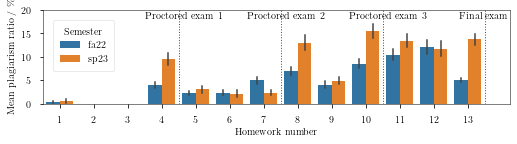

In [50]:
fig, axes = make_fig(figure_width=7.0056, 
                     axis_ratio=5, 
                     top_margin=0.15, 
                     bottom_margin=0.45, 
                     left_margin=0.50, 
                     right_margin=0.01)

sns.barplot(data=homework_marker_ratio_df, x='assessment_number', y='ratio', hue='semester')

plt.axvline(3.5, color='r', ls=':')
plt.axvline(6.5, color='r', ls=':')
plt.axvline(9.5, color='r', ls=':')
plt.axvline(12.5, color='r', ls=':')

plt.text(2.5, 18, 'Proctored exam 1')
plt.text(5.5, 18, 'Proctored exam 2')
plt.text(8.5, 18, 'Proctored exam 3')
plt.text(11.75, 18, 'Final exam')

plt.legend(title='Semester')

plt.xlim(-0.5, 13.25)
plt.ylim(0, 20)

plt.xlabel('Homework number')
plt.ylabel('Mean plagiarism ratio / \%')

plt.savefig('homework_mean_marker_ratio_vs_time.pdf')

# The Linear Regression

In [51]:
def list_2d(num_rows, num_columns):
    return [[None for _ in range(num_columns)] for _ in range(num_rows)]

def homework_between_exams(first_exam, second_exam):
    return [i for i in range(5 + 3 * (first_exam - 1), 5 + 3 * (second_exam - 1), 1)]

# This is the combined regression, taking interaction with semester
def linear_regression(regression_df, first_exam, second_exam):
    return smf.ols(f'exam{second_exam} ~ C(semester)*exam{first_exam} + C(semester)*any_ratio', data=regression_df).fit()

In [52]:
# We did regression for all exam pairs, but only reports the exam1, exam4 pair in the paper
results = list_2d(4, 5)

for first_exam in range(1, 4):
    for second_exam in range(first_exam + 1, 5):
        shared_user_ids = set(score_actual_pivot_df
                              .dropna(subset=[f'exam{first_exam}', 
                                              f'exam{second_exam}'])
                              ['user_id'].unique())
        
        regression_df = (marker_df[(marker_df.assessment_set_name == 'Homework') 
                                   & (marker_df.assessment_number.isin(homework_between_exams(first_exam, 
                                                                                              second_exam))) 
                                   & (marker_df.user_id.isin(shared_user_ids))]
                         .groupby(['semester', 'user_id'])
                         .agg({'any' : 'sum', 'total' : 'sum'}))
        regression_df['any_ratio'] = regression_df['any'] / regression_df.total
        regression_df = regression_df.merge(score_actual_pivot_df, on=['semester', 'user_id'])

        results[first_exam][second_exam] = linear_regression(regression_df, first_exam, second_exam)

In [53]:
parameter = 'Intercept'
print(f'Parameter: {parameter}')
print()
print(f'\t      exam2\t\t      exam3\t\t      exam4')
for first_exam in range(1, 4):
    print(f'exam{first_exam}\t', end='')
    for second_exam in range(2, 5):
        if second_exam <= first_exam:
            print('\t\t\t', end='')
        else:
            print(f'{results[first_exam][second_exam].params[parameter]: .2f}\t', end='')
            print(f'{results[first_exam][second_exam].pvalues[parameter]: .3f}\t\t', end='')
    print()

Parameter: Intercept

	      exam2		      exam3		      exam4
exam1	 2.38	 0.488		-17.30	 0.000		 1.12	 0.780		
exam2				-5.31	 0.090		 15.16	 0.000		
exam3							 31.85	 0.000		


In [54]:
parameter = 'C(semester)[T.sp23]'
print(f'Parameter: {parameter}')
print()
print(f'\t      exam2\t\t      exam3\t\t      exam4')
for first_exam in range(1, 4):
    print(f'exam{first_exam}\t', end='')
    for second_exam in range(2, 5):
        if second_exam <= first_exam:
            print('\t\t\t', end='')
        else:
            print(f'{results[first_exam][second_exam].params[parameter]: .2f}\t', end='')
            print(f'{results[first_exam][second_exam].pvalues[parameter]: .3f}\t\t', end='')
    print()

Parameter: C(semester)[T.sp23]

	      exam2		      exam3		      exam4
exam1	-10.99	 0.021		-7.22	 0.274		-11.03	 0.051		
exam2				 1.04	 0.808		-5.00	 0.183		
exam3							-8.21	 0.002		


In [55]:
parameter = 'first_exam'
print(f'Parameter: {parameter}')
print()
print(f'\t      exam2\t\t      exam3\t\t      exam4')
for first_exam in range(1, 4):
    print(f'exam{first_exam}\t', end='')
    for second_exam in range(2, 5):
        if second_exam <= first_exam:
            print('\t\t\t', end='')
        else:
            print(f'{results[first_exam][second_exam].params[f"exam{first_exam}"]: .2f}\t', end='')
            print(f'{results[first_exam][second_exam].pvalues[f"exam{first_exam}"]: .3f}\t\t', end='')
    print()

Parameter: first_exam

	      exam2		      exam3		      exam4
exam1	 0.96	 0.000		 1.09	 0.000		 0.96	 0.000		
exam2				 0.96	 0.000		 0.81	 0.000		
exam3							 0.67	 0.000		


In [56]:
parameter = 'C(semester)[T.sp23]:first_exam'
print(f'Parameter: {parameter}')
print()
print(f'\t      exam2\t\t      exam3\t\t      exam4')
for first_exam in range(1, 4):
    print(f'exam{first_exam}\t', end='')
    for second_exam in range(2, 5):
        if second_exam <= first_exam:
            print('\t\t\t', end='')
        else:
            print(f'{results[first_exam][second_exam].params[f"C(semester)[T.sp23]:exam{first_exam}"]: .2f}\t', end='')
            print(f'{results[first_exam][second_exam].pvalues[f"C(semester)[T.sp23]:exam{first_exam}"]: .3f}\t\t', end='')
    print()

Parameter: C(semester)[T.sp23]:first_exam

	      exam2		      exam3		      exam4
exam1	 0.06	 0.257		 0.07	 0.321		 0.08	 0.194		
exam2				 0.04	 0.421		 0.06	 0.151		
exam3							 0.06	 0.064		


In [57]:
parameter = 'any_ratio'
print(f'Parameter: {parameter}')
print()
print(f'\t      exam2\t\t      exam3\t\t      exam4')
for first_exam in range(1, 4):
    print(f'exam{first_exam}\t', end='')
    for second_exam in range(2, 5):
        if second_exam <= first_exam:
            print('\t\t\t', end='')
        else:
            print(f'{results[first_exam][second_exam].params[parameter]: .2f}\t', end='')
            print(f'{results[first_exam][second_exam].pvalues[parameter]: .3f}\t\t', end='')
    print()

Parameter: any_ratio

	      exam2		      exam3		      exam4
exam1	-28.89	 0.000		-73.71	 0.000		-54.05	 0.000		
exam2				-46.45	 0.000		-38.20	 0.000		
exam3							-13.58	 0.003		


In [58]:
# Whether there is semester difference of plagirism ratio's impact on learning loss
parameter = 'C(semester)[T.sp23]:any_ratio'
print(f'Parameter: {parameter}')
print()
print(f'\t      exam2\t\t      exam3\t\t      exam4')
for first_exam in range(1, 4):
    print(f'exam{first_exam}\t', end='')
    for second_exam in range(2, 5):
        if second_exam <= first_exam:
            print('\t\t\t', end='')
        else:
            print(f'{results[first_exam][second_exam].params[parameter]: .2f}\t', end='')
            print(f'{results[first_exam][second_exam].pvalues[parameter]: .3f}\t\t', end='')
    print()

Parameter: C(semester)[T.sp23]:any_ratio

	      exam2		      exam3		      exam4
exam1	 1.41	 0.906		 17.04	 0.236		 17.72	 0.094		
exam2				 19.18	 0.047		 19.58	 0.014		
exam3							 10.38	 0.092		


# Linear regression plot

In [59]:
results = []

first_exam = 1
second_exam = 4
shared_user_ids = set(score_actual_pivot_df.dropna(subset=[f'exam{first_exam}', 
                                                              f'exam{second_exam}'])['user_id'].unique())

for semester in ['fa22', 'sp23']:
    regression_df = (marker_df[(marker_df.semester == semester) 
                               & (marker_df.assessment_set_name == 'Homework') 
                               & (marker_df.assessment_number.isin(homework_between_exams(first_exam, 
                                                                                          second_exam))) 
                               & (marker_df.user_id.isin(shared_user_ids))]
                     .groupby(['semester', 'user_id'])
                     .agg({'any' : 'sum', 'total' : 'sum'})
                     .copy())
    regression_df['any_ratio'] = regression_df['any'] / regression_df.total
    regression_df = regression_df.merge(score_actual_pivot_df, on=['semester', 'user_id'])
    regression_df['exam1'] = regression_df['exam1']
    regression_df['exam4'] = regression_df['exam4']
    
    results.append(linear_regression(regression_df, first_exam, second_exam))

In [60]:
print(results[0].summary())

                            OLS Regression Results                            
Dep. Variable:                  exam4   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     399.6
Date:                Fri, 03 May 2024   Prob (F-statistic):          1.45e-107
Time:                        16:51:10   Log-Likelihood:                -2073.3
No. Observations:                 548   AIC:                             4153.
Df Residuals:                     545   BIC:                             4165.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1171      3.755      0.298      0.7

In [61]:
print(results[1].summary())

                            OLS Regression Results                            
Dep. Variable:                  exam4   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     304.8
Date:                Fri, 03 May 2024   Prob (F-statistic):           4.27e-83
Time:                        16:51:10   Log-Likelihood:                -1691.0
No. Observations:                 432   AIC:                             3388.
Df Residuals:                     429   BIC:                             3400.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.9110      4.277     -2.317      0.0

In [62]:
regression_result_df = pd.DataFrame.from_dict({
    'Semester' : ['sp23', 'fa22'], 
    'Gamma' : [-results[1].params['any_ratio'], -results[0].params['any_ratio']], 
    'sd' : [(results[1].conf_int()[1]['any_ratio'] - results[1].conf_int()[0]['any_ratio']) / 2,
            (results[0].conf_int()[1]['any_ratio'] - results[0].conf_int()[0]['any_ratio']) / 2]
})

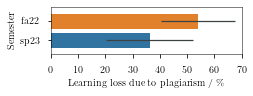

In [63]:
fig, axes = make_fig(figure_width=3.3367, 
                     axis_ratio=4, 
                     top_margin=0.01, 
                     bottom_margin=0.48, 
                     left_margin=0.62, 
                     right_margin=0.07)

sns.barplot(data=regression_result_df, x='Gamma', y='Semester', hue='Semester', orient='h',
            order=['sp23', 'fa22'])

plt.errorbar(y=[0, 1], x=regression_result_df['Gamma'], xerr=regression_result_df['sd'], 
             lw=1.25, fmt='none', c='#3c4142')

plt.xlim(0, 70)
plt.ylim(-0.75, 1.75)

plt.xticks(np.arange(0, 71, 10))

plt.xlabel(r'Learning loss due to plagiarism / \%')

plt.savefig('regression_gamma.pdf')

# Correlations between Marker Ratios and Final Exam Scores

In [64]:
def format_pvalue(pvalue):
    if pvalue < 0.001:
        return f'<0.001^{{***}}'
    elif pvalue < 0.01:
        return f'{pvalue:.3f}^{{**}}'
    elif pvalue < 0.05:
        return f'{pvalue:.3f}^{{*}}'
    else:
        return f'{pvalue:.3f}'

correlation_df = marker_ratio_pivot_df.merge(score_predicted_pivot_df, on=['semester', 'user_id'])
for marker in ['syntax', 'comment', 'print', 'code', 'any']:
    for semester in ['fa22', 'sp23']:
        print(marker, semester)
        for assessment in ['homework', 'quiz', 'exam']:
            sub_df = correlation_df.dropna(subset=[f'{marker}_{assessment}', 'exam4'])
            sub_df = sub_df[sub_df.semester == semester]
            res = scipy.stats.pearsonr(sub_df[f'{marker}_{assessment}'], sub_df['exam4'])
            print(f' & ${res.correlation:.2f} \; ({format_pvalue(res.pvalue)})$', end='')
        print()

syntax fa22
 & $-0.19 \; (<0.001^{***})$ & $-0.09 \; (0.031^{*})$ & $-0.01 \; (0.810)$
syntax sp23
 & $-0.27 \; (<0.001^{***})$ & $-0.25 \; (<0.001^{***})$ & $0.06 \; (0.228)$
comment fa22
 & $-0.31 \; (<0.001^{***})$ & $-0.24 \; (<0.001^{***})$ & $0.13 \; (0.002^{**})$
comment sp23
 & $-0.25 \; (<0.001^{***})$ & $-0.13 \; (0.009^{**})$ & $0.19 \; (<0.001^{***})$
print fa22
 & $-0.53 \; (<0.001^{***})$ & $-0.39 \; (<0.001^{***})$ & $-0.06 \; (0.153)$
print sp23
 & $-0.24 \; (<0.001^{***})$ & $-0.16 \; (0.001^{**})$ & $-0.05 \; (0.275)$
code fa22
 & $-0.51 \; (<0.001^{***})$ & $-0.42 \; (<0.001^{***})$ & $-0.03 \; (0.431)$
code sp23
 & $-0.17 \; (<0.001^{***})$ & $-0.09 \; (0.056)$ & $-0.06 \; (0.248)$
any fa22
 & $-0.44 \; (<0.001^{***})$ & $-0.37 \; (<0.001^{***})$ & $0.11 \; (0.009^{**})$
any sp23
 & $-0.34 \; (<0.001^{***})$ & $-0.26 \; (<0.001^{***})$ & $0.09 \; (0.065)$


# Scatter Plot of Final Exam Scores vs Marker Ratios, Homework  vs Exam

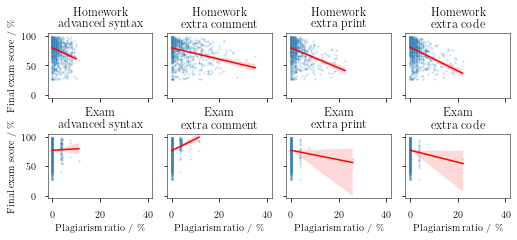

In [65]:
fig, axes = make_fig_array(n_vert=2, 
                           n_horiz=4, 
                           figure_width=7.0056, 
                           axis_ratio=1.618, 
                           top_margin=0.38, 
                           bottom_margin=0.48, 
                           left_margin=0.57, 
                           right_margin=0.01, 
                           horiz_sep=0.20, 
                           vert_sep=0.50, 
                           share_x_axes=True, 
                           share_y_axes=True)

remove_fig_array_axes(axes, remove_x_axes=True, remove_y_axes=True)

assessments = ['homework', 'exam']
markers = ['syntax', 'comment', 'code', 'print']
markers_full = ['advanced syntax', 'extra comment', 'extra print', 'extra code']

for i in range(2):
    for j in range(4):
        sns.scatterplot(data=correlation_df, 
                        x=f'{markers[j]}_{assessments[1 - i]}', 
                        y='exam4', 
                        alpha=0.25, 
                        s=5, 
                        linewidth=0.1, 
                        ax=axes[i][j])
        
        sns.regplot(data=correlation_df, 
                    x=f'{markers[j]}_{assessments[1 - i]}', 
                    y='exam4', 
                    scatter=False, 
                    seed=32,
                    color='red', 
                    ax=axes[i][j])
        
        axes[i][j].set_title(f'{assessments[1 - i].capitalize()}\n{markers_full[j]}')
        axes[i][j].set_xlim(-2, 42)
        axes[i][j].set_ylim(-5, 105)
        
        if i == 0:
            axes[i][j].set_xlabel('Plagiarism ratio / \%')
        else:
            axes[i][j].set_xlabel('')
        if j == 0:
            axes[i][j].set_ylabel('Final exam score / \%')
        else:
            axes[i][j].set_ylabel('')

plt.savefig('scatter_plot.pdf')

# Mean Marker Ratios by Assessment Type

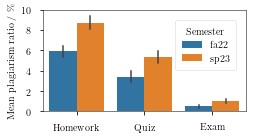

In [66]:
fig, axes = make_fig(figure_width=3.3367, 
                     axis_ratio=2, 
                     top_margin=0.10, 
                     bottom_margin=0.29, 
                     left_margin=0.50, 
                     right_margin=0.01)

sns.barplot(data=marker_ratio_df[marker_ratio_df.marker=='any'], 
            x='assessment_set_name', y='ratio', hue='semester', 
            order=['Homework', 'Quiz', 'Exam'])

plt.legend(title='Semester')

plt.ylim(0, 10)

plt.xlabel(r'')
plt.ylabel(r'Mean plagiarism ratio / \%')

plt.savefig('mean_marker_ratio_by_assessment_type.pdf')